In [1]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import scipy.sparse

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


In [2]:
SEED = 123
DRAWS = 10000
BURNIN = 2000
TUNE = 2000
CHAINS = 4
CORES = 2

# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [3]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


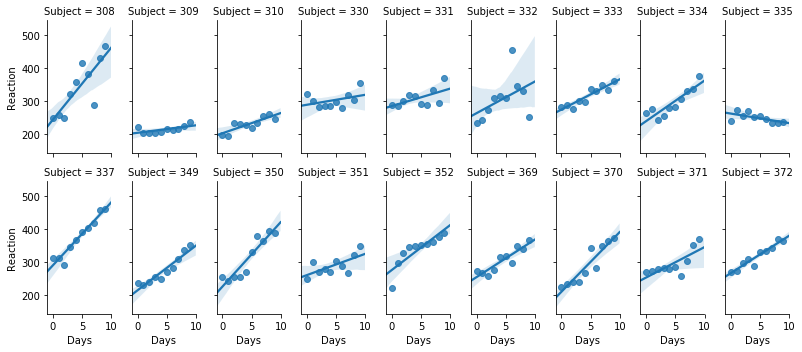

In [4]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.5, size=2.5);

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [5]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [6]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [7]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [9]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [10]:
Y = np.asarray(sleep['Reaction'])

In [11]:
## see also https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_13.ipynb
n_random_effects = X.shape[1]
n_subjects = Z_intercept.shape[1]

with pm.Model() as model:

    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=1000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
        
    ## Random effect
    # Prior on the standard deviation of the random effects
    sigma_Z = pm.HalfNormal.dist(sd=100, shape=n_random_effects)
    
    # Build the covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=n_random_effects, eta=2, sd_dist=sigma_Z)
    chol = pm.expand_packed_triangular(n_random_effects, chol_packed, lower=True)
    
    covariance_matrix = pm.Deterministic('covariance_matrix', tt.dot(chol, chol.T))
    
    # Extract the standard deviations and rho
    standard_deviations = pm.Deterministic('standard_deviations', tt.sqrt(tt.diag(covariance_matrix)))
    correlation_matrix = pm.Deterministic('correlation_matrix', tt.diag(standard_deviations**-1).dot(covariance_matrix.dot(tt.diag(standard_deviations**-1))))
    rho = pm.Deterministic('rho', correlation_matrix[np.triu_indices(2, k=1)])
       
    # Centered parametrization
    #gamma_Z = pm.MvNormal('gamma_Z', mu=np.zeros(n_random_effects), chol=chol, shape=(n_subjects, n_random_effects))
    #tt.printing.Print('gamma_Z')(gamma_Z.shape)
    
    ## Alternative Non centered
    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=(n_subjects, n_random_effects))
    gamma_Z = pm.Deterministic('gamma_Z', tt.dot(chol, gamma_Z_raw.T).T)
    
    # Separate the coefficients for intercept and slope
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z[:, 0])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z[:, 1])
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 

    ## likelihood
    mu_estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, chol_packed, beta_X_slope, beta_X_intercept]


In [12]:
trace = trace[BURNIN:] # discard burnin

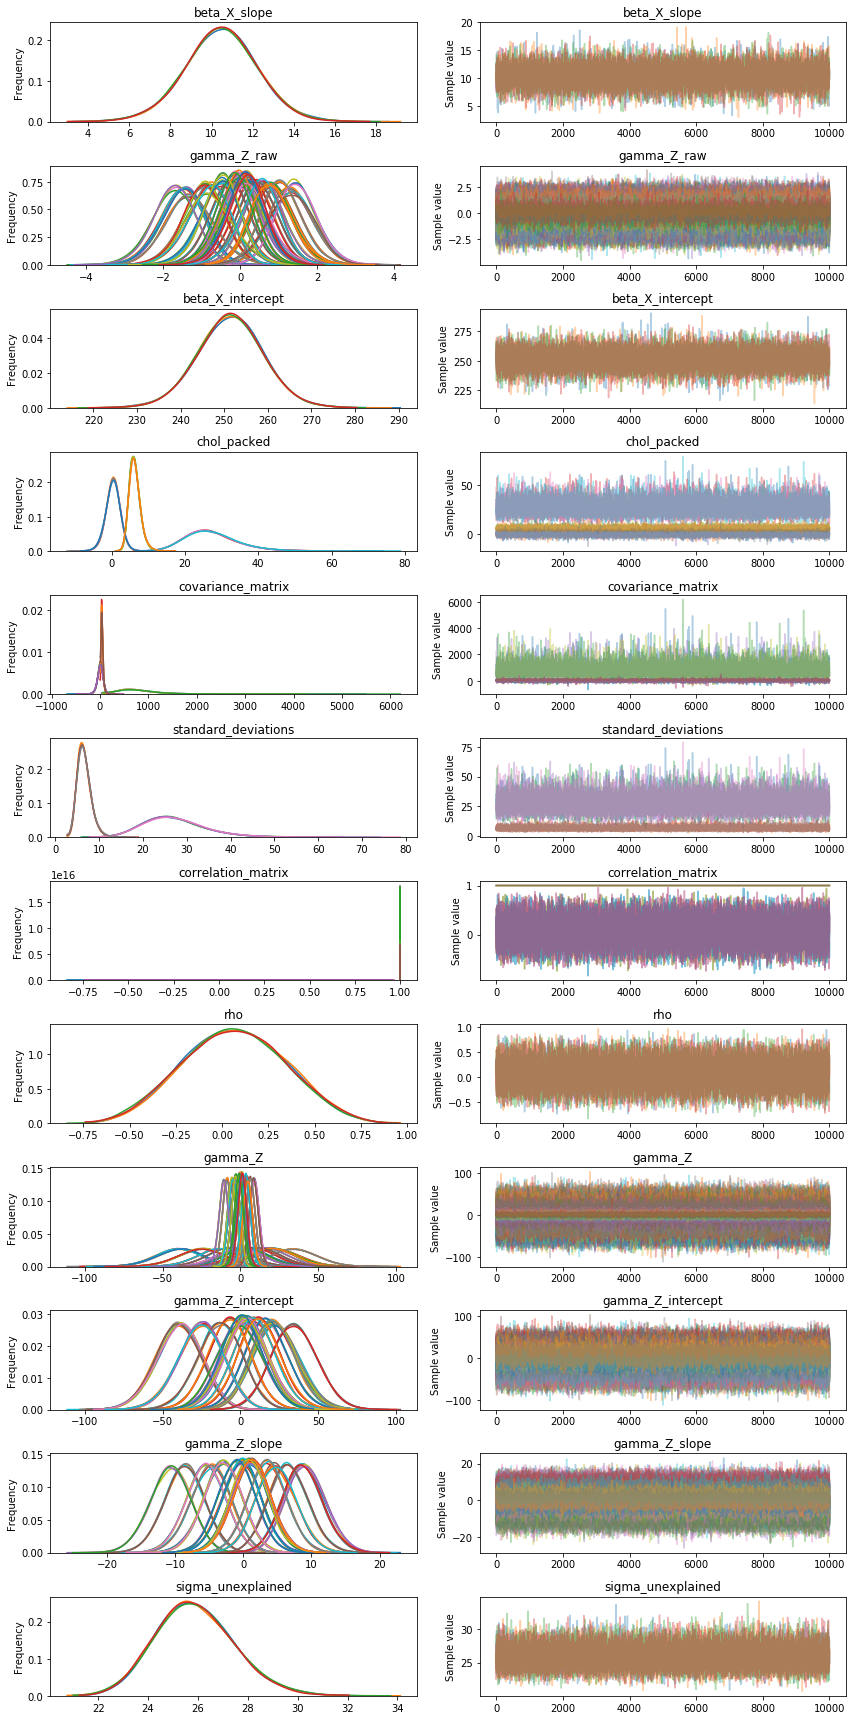

In [13]:
_ = pm.traceplot(trace)

In [14]:
covariance_matrix = np.mean(trace['covariance_matrix'], 0)
covariance_matrix

array([[792.37428678,   6.99782162],
       [  6.99782162,  45.54674587]])

In [15]:
standard_deviations = np.mean(trace['standard_deviations'], 0)
standard_deviations

array([27.26823228,  6.57167616])

In [16]:
correlation_matrix = np.mean(trace['correlation_matrix'], 0)
correlation_matrix

array([[1.        , 0.06660339],
       [0.06660339, 1.        ]])

In [17]:
rho = np.mean(trace['rho'], 0)
rho

array([0.06660339])

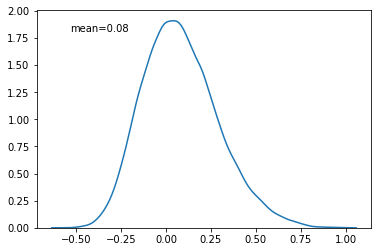

In [18]:
rho_1 = []

for i in trace['gamma_Z']:
    rho_1.append(np.corrcoef(i.T)[0, 1])
    
fig, ax = plt.subplots(1, 1)
sns.kdeplot(rho_1, ax=ax)
ax.text(0.1, 0.9, 'mean={}'.format(np.round(np.mean(rho_1), 2)), transform=ax.transAxes);

In [19]:
trace.add_values({'rho_1':np.asarray(rho_1)})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D12839B588>,
      dtype=object)

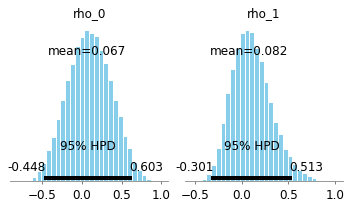

In [20]:
pm.plot_posterior(trace, varnames=['rho', 'rho_1'], figsize=(5, 3))

In [21]:
pm.summary(trace, varnames=['rho', 'rho_1'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
rho__0,0.066603,0.273428,0.002153,-0.448047,0.603161,13250.279118,1.000183
rho_1,0.081810,0.210250,0.001207,-0.300736,0.512913,27161.207956,1.000009


In [22]:
trace_df = pm.trace_to_dataframe(trace)

In [23]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

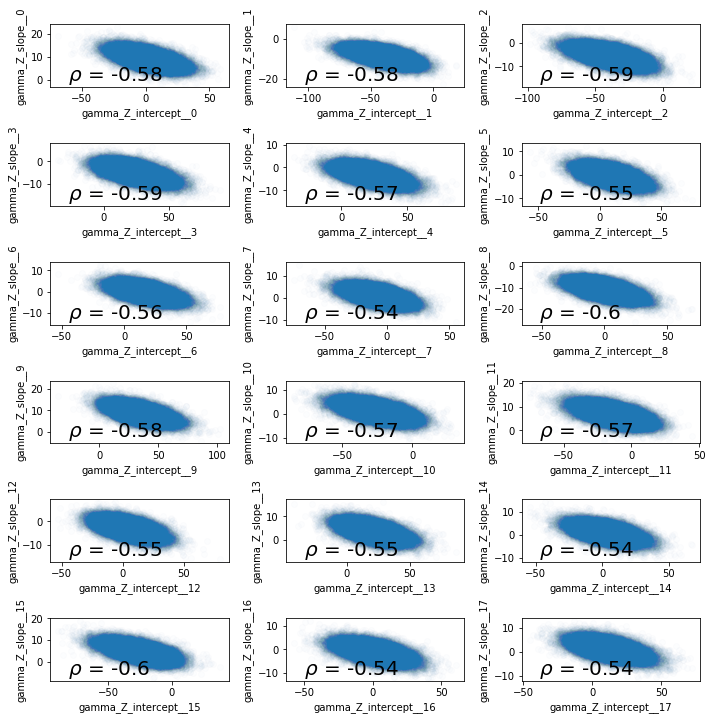

In [24]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    axi.text(0.1, 0.1, '$\\rho$ = {}'.format(np.round(np.corrcoef(trace_df[xvars[i]], trace_df[yvars[i]])[0, 1], 2)),
             fontsize=20, transform=axi.transAxes)
    
plt.tight_layout()

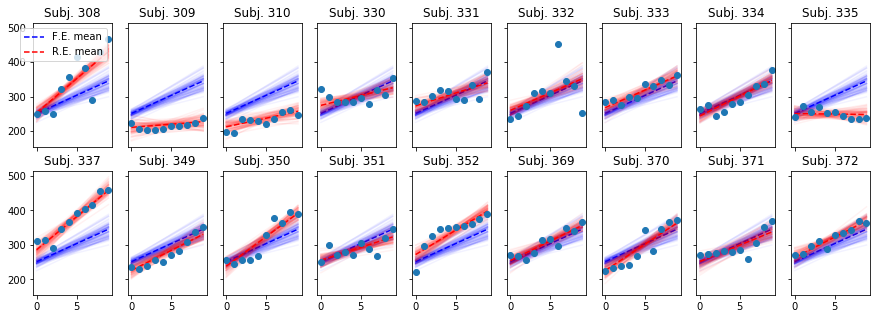

In [25]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0, g1 in zip(trace_df['beta_X_intercept'][::500], 
                              trace_df['beta_X_slope'][::500],
                              trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                              trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

In [26]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|██████████████████████| 250/250 [00:00<00:00, 896.53it/s]


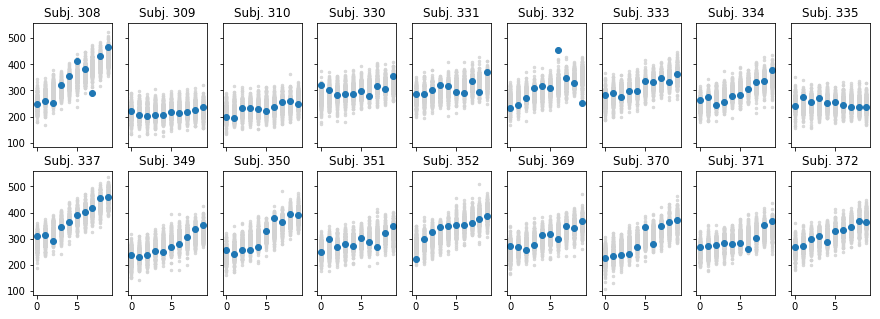

In [27]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


In [28]:
waic = pm.waic(trace, model)
waic.WAIC

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1719.5921847272566

In [29]:
loo = pm.loo(trace, model)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1723.774176972841